In [211]:
import json
import os
from enum import Enum
from typing import List, Optional, Literal, Dict

from IPython.display import display, Image
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_ollama import ChatOllama
from langgraph.graph import START, END, StateGraph, MessagesState
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Annotated
import operator
from src.services.retrival_engine import RetrivalEngine
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langchain_core.messages import get_buffer_string

os.environ.clear()
load_dotenv()

True

In [ ]:

import pandas as pd

df_2 = pd.read_excel('urls.xlsx')
df_2

# LLM

In [ ]:
local_llm = "llama3.2:latest"
model_tested = "llama3.2:latest"
metadata = f"CRAG, {model_tested}"

# Create Index
Let's index 3 blog posts

In [ ]:
# urls = [
#     "https://lpi.oregonstate.edu/sites/lpi.oregonstate.edu/files/pdf/mic/micronutrients_for_health.pdf",
#     # "https://www.accessdata.fda.gov/scripts/InteractiveNutritionFactsLabel/assets/InteractiveNFL_Vitamins%26MineralsChart_October2021.pdf",
#
#     "https://www.hilarispublisher.com/open-access/essential-nutrients-in-human-body.pdf",
# ]
#
# # Load documents from the URLs
# docs = [PyPDFLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]
#
# # Initialize a text splitter with specified chunk size and overlap
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=600, chunk_overlap=100
# )
#
# # Create a retrival Engine
# retrival_engine = RetrivalEngine()
#
# # Split the documents into chunks
# doc_splits = text_splitter.split_documents(docs_list)
#
# contents = [doc.page_content for doc in doc_splits]
# metadatas = []
#
# for doc in doc_splits:
#     metadata = dict(doc.metadata)
#     metadata["content"] = "nutrition_article"
#     metadatas.append(metadata)
#
# # Add items to retrival engine in smaller batches
# batch_size = 10
# for i in range(0, len(contents), batch_size):
#     batch_contents = contents[i:i + batch_size]
#     batch_metadatas = metadatas[i:i + batch_size]
#
#     # This will use the cache for any existing embeddings
#     ids = retrival_engine.bulk_add_items(
#         contents=batch_contents,
#         metadatas=batch_metadatas,
#         item_types=["nutrition_document"] * len(batch_contents)
#     )
#
# print("All documents stored in Pinecone!")


# Building the graph

## Document retriver

In [ ]:
class UserProfile(BaseModel):
    name: Optional[str] = Field(None, description="User's full name")
    age: int = Field(..., ge=0, le=120, description="User's age")
    gender: str = Field(..., description="Male, Female, or Other")
    height_cm: int = Field(..., gt=50, lt=250, description="Height in cm")
    weight_kg: float = Field(..., gt=20, lt=300, description="Weight in kg")
    activity_level: str = Field(...,
                                description="Sedentary, Lightly active, Moderately active, Very active, Super active")
    dietary_preferences: List[Literal[
        "Vegetarian", "Vegan", "Pescatarian", "Keto", "Paleo",
        "Gluten-Free", "Dairy-Free", "Nut-Free", "Halal", "Kosher",
        "Low-Carb", "Low-Fat", "High-Protein", "Mediterranean", "FODMAP", "Sugar-Free"
    ]] = Field(default=[], description="User's dietary preferences, can be one or more.")
    allergies: List[str] = Field(default=[], description="User's allergies")
    health_conditions: List[str] = Field(default=[], description="Any medical conditions")
    weight_goal: str = Field(..., description="Lose weight, Maintain weight, Gain muscle")
    past_meals: List[str] = Field(default=[], description="Past meals")


user_profile = {
    "name": "Space Cadet",
    "age": 23,
    "gender": "Male",
    "height_cm": 183,
    "weight_kg": 65,
    "activity_level": "Lightly active",
    "dietary_preferences": ["Dairy-Free", "Low-Carb"],
    "allergies": ["Peanuts"],
    "health_conditions": ["None"],
    "weight_goal": "Maintain weight"
}

user = UserProfile(**user_profile)
past_meals = []
print(user.model_dump_json(indent=4))

In [ ]:
llm = ChatOllama(model=local_llm, format="json", temperature=0)
llm_json_mode = ChatOllama(model=local_llm, format="json", temperature=0)

# Retrieval Prompt Template for Multiple Meal Plans
retriever_prompt = PromptTemplate(
    template="""
    You are a nutritionist AI assistant that helps users generate **personalized meal recommendations** based on their profile.

    The user profile is as follows:

    - Age: {age}
    - Gender: {gender}
    - Height: {height_cm} cm
    - Weight: {weight_kg} kg
    - Activity Level: {activity_level}
    - Dietary Preferences: {dietary_preferences}
    - Allergies: {allergies}
    - Health Conditions: {health_conditions}
    - Weight Goal: {weight_goal}
    - Past Meal History (if available): {past_meals}

    ### Task:
    Generate a structured JSON response with **multiple queries** for retrieving meal plans.
    Each query should focus on **one meal category**:
    - Breakfast
    - Lunch
    - Dinner
    - Snacks

    Ensure that meals align with **dietary preferences, allergies, and weight goals** while maintaining **nutritional balance**.

    Rules:
	•	If any field is an empty array `[]`, or unspecified, substitute it with a realistic, healthy default (e.g., “Mediterranean diet”, “moderately active”, “no known allergies”, etc.).
	•	If dietary preference is missing, randomly choose a healthy eating pattern such as Mediterranean, Plant-based, Paleo, or Flexitarian.
	•	Ensure that meals align with all available preferences, allergies, and weight goals while maintaining nutritional balance.


    Your output must be a valid JSON object structured as follows:
    ```json
    {{
        "queries": [
            {{
                "meal_type": "BREAKFAST",
                "query": "Retrieve high-protein breakfast meals suitable for {gender}, {age} years old, {activity_level} activity, avoiding {allergies}."
            }},
            {{
                "meal_type": "LUNCH",
                "query": "Retrieve balanced lunch options with {dietary_preferences} for a {weight_goal} goal, avoiding {allergies}."
            }},
            {{
                "meal_type": "DINNER",
                "query": "Find nutritious dinners for {age}-year-old {gender} aiming to {weight_goal}."
            }},
            {{
                "meal_type": "SNACKS",
                "query": "Suggest healthy snack options that fit within a {dietary_preferences} diet while avoiding {allergies}."
            }}
        ]
    }}
    ```
    """,
    input_variables=[
        "age",
        "gender",
        "height_cm",
        "weight_kg",
        "activity_level",
        "dietary_preferences",
        "allergies",
        "health_conditions",
        "weight_goal",
        "past_meals"
    ],
)

# Output Parser
output_parser = JsonOutputParser()


class MealQuery(TypedDict):
    meal_type: Literal["BREAKFAST", "LUNCH", "DINNER"]
    query: str


# Function to Generate Multiple Queries
def generate_retrieval_queries(user_profile, llm) -> List[MealQuery]:
    formatted_prompt = retriever_prompt.format(**user_profile)
    response = llm.invoke(formatted_prompt)
    return output_parser.parse(response.content).get("queries", [])


# Example User Profile
# user_profile = {
#     "age": 28,
#     "gender": "Male",
#     "height_cm": 183,
#     "weight_kg": 65,
#     "activity_level": "Moderately active",
#     "dietary_preferences": [],
#     "allergies": [],
#     "health_conditions": [],
#     "weight_goal": "Maintain weight",
#     "past_meals": ["Oatmeal with fruits", "Grilled chicken with rice", "Salmon with vegetables"],
# }

user_profile = {
    "name": "Space Cadet",
    "age": 23,
    "gender": "Male",
    "height_cm": 183,
    "weight_kg": 65,
    "activity_level": "Lightly active",
    "dietary_preferences": ["Dairy-Free", "Low-Carb"],
    "allergies": ["Peanuts"],
    "health_conditions": ["None"],
    "weight_goal": "Maintain weight",
    "past_meals": ["Oatmeal with fruits", "Grilled chicken with rice", "Salmon with vegetables"],
}
# Generate queries
queries_info = generate_retrieval_queries(user_profile, llm_json_mode)
print(queries_info)

In [ ]:
# # Function to get retrival docs
# # Create a retrival Engine
# retrival_engine = RetrivalEngine()
# class RetrievedDocuments(BaseModel):
#     meal_type: str
#     query: str
#     docs: List[str]
#
#
# def retrieve_docs(queries_info, retriver):
#     all_results = []
#     for query_info in queries_info:
#         query = query_info["query"]
#         meal_type = query_info["meal_type"]
#         retreived_docs = retriver.get_retrivals(query, top_k=2)
#         all_results.append(RetrievedDocuments(meal_type=meal_type, query=query,
#                                               docs=list(map(lambda x: x["metadata"]["content"], retreived_docs))))
#
#     return all_results
#
#
# queries_info = generate_retrieval_queries(user_profile, llm_json_mode)
# results = retrieve_docs(queries_info, retrival_engine)
# results

In [ ]:
# len(results)

## Router

In [ ]:
router_instructions = """
You are an expert in routing user health profiles to the most relevant data source. Your task is to determine whether a query should be answered using a vectorstore or a web search.
	•	The vectorstore contains documents related to nutrition and food for health. Use this for queries specifically about diet, nutrition, or health-related food topics.
	•	For all other topics, especially current events, use web search as the data source.
	•	Your response must be a JSON object with a single key, datasource, whose value is either 'vectorstore' or 'websearch'. example: {"datasource": "vectorstore"} or {"datasource": "websearch"}

Ensure your decision-making is clear, accurate, and follows these rules strictly.
"""

# Testing
test_web_search = llm_json_mode.invoke(
    [SystemMessage(router_instructions), HumanMessage("What are the benefits of turmeric?")]
)
test_web_search2 = llm_json_mode.invoke(
    [SystemMessage(router_instructions), HumanMessage("Who is the president of the United States?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search2.content)
)

## Retrival Grader

## Intializing Chat Gpt

In [ ]:
from typing import Any, Union

load_dotenv()

from langchain_openai import ChatOpenAI

llm_chat = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm_chat_json = llm_chat.with_structured_output(method="json_mode")

In [ ]:

# doc_grader_instructions = """
# You are a grader assessing the quality and relevance of a retrieved nutrition document to a user's profile and a specified meal type.
#
# Evaluate whether the document provides useful, accurate, and practical nutritional information that aligns with health and dietary topics, as well as the specified meal type.
#
# If the document contains scientifically valid and actionable insights on nutrition and is relevant to the given meal type, grade it as relevant.
# """

doc_grader_prompt = """
You are a grader assessing the quality and relevance of a retrieved nutrition document to a user's profile and a specified meal type.

Evaluate whether the document provides useful, accurate, and practical nutritional information that aligns with health and dietary topics, as well as the specified meal type.

If the document contains scientifically valid and actionable insights on nutrition and is relevant to the given meal type, grade it as relevant.


Here is the retrieved nutrition document: \n\n {document} \n\n
Here is the user's profile: \n\n {user_profile} \n\n if the users profile
Meal type: {meal_type} \n\n
Here is the grading criteria:
- The document should be scientifically accurate and credible.
- It should be relevant to nutrition and health-related topics.
- It should provide clear, actionable, and practical guidance.
- It should align with the specified meal type ({meal_type}).

Carefully and objectively assess whether the document meets these criteria.

Your answer should include:
1. A binary score of 'yes' or 'no'.
2. A reason of why you gave that score, based on the criteria.

Return JSON with a 2 keys, binary_score and reason as to why it reached that criteria
"""


class MealTypes(Enum):
    BREAKFAST = "Breakfast"
    LUNCH = "Lunch"
    DINNER = "Dinner"
    SNACKS = "Snacks"


# class DocumentMetadata(BaseModel):
#     content: str
#     creationdate: Optional[str]
#     creator: Optional[str]
#     item_type: str
#     moddate: Optional[str]
#     page: Optional[float]
#     page_label: Optional[str]
#     producer: Optional[str]
#     source: Optional[str]
#     total_pages: Optional[float]
#     trapped: Optional[str]

#
# class RetrievedDocumentsMetadata(BaseModel):
#     id: str
#     score: float
#     metadata: DocumentMetadata


# def grade_documents(user_profile, retrieve_docs, meal_type:MealTypes) -> GradedDocuments:
#     grade_documents:List[GradedDocuments] = []
#
#     for doc in retrieve_docs:
#         doc_content = doc["metadata"]["content"]
#         formatted_prompt = doc_grader_prompt.format(document=doc_content, user_profile=user_profile, meal_type=meal_type.value)
#         graded_response = llm_chat_json.invoke(formatted_prompt)
#
#
#     return grade_documents
#
# grade_documents = grade_documents(user_profile, results["BREAKFAST"], MealTypes.BREAKFAST)
class ValidatedDocument(BaseModel):
    valid: bool
    doc: Union[Optional[Dict[str, str]], Any]
    reaseon: Optional[str]


class GradedMealTypes(BaseModel):
    meal_type: str
    query: str
    validated_docs: List[ValidatedDocument]


class GraderResponse(BaseModel):
    binary_score: Literal["yes", "no"]
    reason: str

# function to grade the documents
# def grade_documents(profile: UserProfile, retrieved_docs: List[RetrievedDocuments]) -> List[GradedMealTypes]:
#     print(f"User profile: \n {profile}")
#     result: List[GradedMealTypes] = []
#     for retrieved_documents in retrieved_docs:
#         meal_type = retrieved_documents.meal_type
#         query = retrieved_documents.query
#         to_input = GradedMealTypes(meal_type=meal_type, query=query, validated_docs=[])
#         valid_docs: List[ValidatedDocument] = []
#
#         print(f"===== checking for meal_type: {meal_type} =====")
#         for index, doc_content in enumerate(retrieved_documents.docs):
#             formatted_prompt = doc_grader_prompt.format(document=doc_content, meal_type=meal_type,
#                                                         user_profile=json.dumps(profile, indent=4))
#
#             graded_response = llm_chat_json.invoke(formatted_prompt)
#
#             print(f"\tgraded_response for document {index + 1}: {graded_response["binary_score"]}")
#             if graded_response["binary_score"] == "yes":
#                 print("\tThe document is:")
#                 print(f"\n\t\t{doc_content}")
#                 valid_docs.append(ValidatedDocument(valid=True, doc=doc_content, reaseon=graded_response["reason"]))
#             else:
#                 print(f"\t\tThe document is: \n\t\t{doc_content}")
#                 valid_docs.append(ValidatedDocument(valid=False, doc=doc_content, reaseon=graded_response["reason"]))
#
#         to_input.validated_docs = valid_docs
#
#         result.append(to_input)
#
#     return result
#
#
# grade_meal_documents = grade_documents(user_profile, results)
# grade_meal_documents


In [ ]:
len(grade_meal_documents)

In [ ]:
len(grade_meal_documents[0].validated_docs)

# Reaseach Agent to help refined retrieved documents
![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [109]:
from langgraph.graph import add_messages
from langchain_core.messages import AnyMessage


# class Analyst(BaseModel):
#     affiliation: str = Field(
#         description="Primary affiliation of the analyst",
#     )
#     name: str = Field(
#         description="Name of the analyst",
#     )
#     role: str = Field(
#         description="Role of the analyst in the context of the topic",
#     )
#     description: str = Field(
#         description="Description of the analyst focus, concerns, and motives.",
#     )
#
#     @property
#     def person(self) -> str:
#         return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# class Perspectives(BaseModel):
#     analysts: List[Analyst] = Field(
#         description="Comprehensive list of analysts with their roles and affiliations.",
#     )
class Analyst(BaseModel):
    name: str
    tone: str
    theme: str
    description: str


class MealTypeAnalysts(BaseModel):
    meal_type: str
    analysts: List[Analyst]


class AnalystMessages(MessagesState):
    analyst: Analyst


class GenerateAnalystsState(TypedDict):
    user_profile: UserProfile  # The user's profile
    meal_queries: List[MealQuery]
    # topic: str  # Research topic
    max_analysts: int  # Number of analysts
    analysts: List[MealTypeAnalysts]  # Analyst asking questions
    graded_meal_documents: List[GradedMealTypes]  # List of the graded meal types


### Old prompt

meal_assistant_prompt = """
You are an AI tasked with generating a set of meal assistant personas based on user-specific dietary context. Follow these instructions carefully and respond in valid JSON format.

1. Review the user's profile to understand their dietary habits, preferences, restrictions, and goals:
{user_profile}

2. Examine the retrieved document provided below. This document has been evaluated by another AI reviewer.

Document:
{retrieved_document}

AI Review Summary:
- Query used to retrieve the document: {query_topic}
- Document validity: {document_validity}
- Feedback: {document_feedback}

3. Consider the type of meal for which these assistants are being created:
{meal_type}

4. Based on the document content, its validity, and the user profile, identify the most important themes. Themes may relate to dietary needs, health goals, preparation time, cultural relevance, food variety, or lifestyle factors.

5. Select the top {max_assistants} relevant themes for the current meal context.

6. For each selected theme, create one unique AI assistant persona. Each assistant must:
    - Have a distinct name and tone (e.g., cheerful, nurturing, analytical).
    - Focus on one specific theme informed by the query, the document, and the AI feedback.
    - Be customized to assist the user specifically for {meal_type} planning or decisions.
    - Offer suggestions or support that reflect both the user's goals and the information from the document.

Return your output as a valid JSON object matching this structure:
{{
  "analysts": [
    {{
      "name": "<assistant_name>",
      "tone": "<tone_description>",
      "theme": "<core_theme>",
      "description": "<brief description of this persona and how it helps the user for this meal>"
    }}
  ]
}}
Ensure the top-level key is "analysts".
"""

### Old analyst function
def create_analysts(state: GenerateAnalystsState):
    llm_chat_json = llm_chat.with_structured_output(method="json_mode")
    max_assistants = state["max_analysts"]
    graded_meal_documents = state["graded_meal_documents"]
    user_profile = state["user_profile"]
    result: List[MealTypeAnalysts] = []

    for graded_meal in graded_meal_documents:
        meal_type = graded_meal.meal_type
        query = graded_meal.query
        validated_docs = graded_meal.validated_docs

        for validated_doc in validated_docs:
            system_message = meal_assistant_prompt.format(
                user_profile=json.dumps(user_profile),
                retrieved_document=validated_doc.doc,
                document_validity=False,
                document_feedback=validated_doc.reaseon,
                meal_type=meal_type,
                max_assistants=max_assistants,
                query_topic=query
            )
            analysts = llm_chat_json.invoke(
                [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

            generated_analyst = MealTypeAnalysts(
                meal_type=meal_type,
                analysts=analysts["analysts"],
            )

            result.append(generated_analyst)

    # Write to state
    return {"analysts": result}

In [ ]:
queries_info

In [286]:
meal_assistant_prompt = """
You are an AI tasked with generating a set of meal assistant personas based solely on a user's dietary context. Follow these instructions carefully and respond in valid JSON format.

1. Review the user's profile to understand their dietary habits, preferences, restrictions, and goals:
{user_profile}

2. Consider the type of meal for which these assistants are being created:
{meal_type} and the following instruction: {query}

3. Identify the most important themes from the user's profile. Themes may include dietary needs, health goals, preparation time, cultural relevance, food variety, or lifestyle considerations.

4. Select the top {max_assistants} relevant themes for the current meal context.

5. For each selected theme, create one unique AI assistant persona. Each assistant must:
    - Have a distinct name and tone (e.g., cheerful, nurturing, analytical).
    - Focus on one specific theme derived from the user profile.
    - Be customized to assist the user specifically for {meal_type} planning or decisions.
    - Offer helpful suggestions or support that reflect the user’s goals and context.

Return your output as a valid JSON object matching this structure:
[
    {{
      "name": "<assistant_name>",
      "tone": "<tone_description>",
      "theme": "<core_theme>",
      "description": "<brief description of this persona and how it helps the user for this meal>"
    }}
    ,.....
  ]
Ensure the top-level key is "analysts".
"""

llm_chat = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


def create_analysts(state: GenerateAnalystsState):
    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    llm_chat_json = llm_chat.with_structured_output(method="json_mode")
    max_assistants = state["max_analysts"]
    meal_queries = state["meal_queries"]
    user_profile = state["user_profile"]

    result: List[MealTypeAnalysts] = []

    for meal in meal_queries:
        meal_type = meal["meal_type"]
        query = meal["query"]

        system_message = meal_assistant_prompt.format(
            user_profile=json.dumps(user_profile),
            meal_type=meal_type,
            query=query,
            max_assistants=max_assistants,
        )

        analysts = llm_chat_json.invoke(
            [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

        generated_analyst = MealTypeAnalysts(
            meal_type=meal_type,
            analysts=analysts["analysts"],
        )

        result.append(generated_analyst)

    # Write to state
    return {"analysts": result}


builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analyst", create_analysts)
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", END)

create_analyst_graph = builder.compile()

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/JSV7aW5pdDogeydmbG93Y2hhcnQnOiB7J2N1cnZlJzogJ2xpbmVhcid9fX0lJQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWNyZWF0ZV9hbmFseXN0KGNyZWF0ZV9hbmFseXN0KQoJX19lbmRfXyhbPHA+X19lbmRfXzwvcD5dKTo6Omxhc3QKCV9fc3RhcnRfXyAtLT4gY3JlYXRlX2FuYWx5c3Q7CgljcmVhdGVfYW5hbHlzdCAtLT4gX19lbmRfXzsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 6705


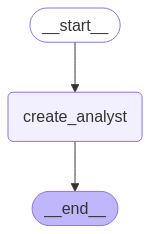

In [287]:
display(Image(create_analyst_graph.get_graph(xray=1).draw_mermaid_png()))

In [288]:
queries_info

[{'meal_type': 'BREAKFAST',
  'query': "Retrieve high-protein breakfast meals suitable for Male, 23 years old, Lightly active activity, avoiding ['Peanuts']."},
 {'meal_type': 'LUNCH',
  'query': "Retrieve balanced lunch options with ['Dairy-Free', 'Low-Carb'] for a Maintain weight goal, avoiding ['Peanuts']."},
 {'meal_type': 'DINNER',
  'query': 'Find nutritious dinners for 23-year-old Male aiming to Maintain weight.'},
 {'meal_type': 'SNACKS',
  'query': "Suggest healthy snack options that fit within a ['Dairy-Free', 'Low-Carb'] diet while avoiding ['Peanuts']."}]

In [323]:
# Input
max_analysts = 1
# topic = grade_meal_documents[0].query
# graded_meal_documents = grade_meal_documents
# thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in create_analyst_graph.stream({"max_analysts": max_analysts,
                                          "meal_queries": queries_info, "user_profile": user_profile},
                                         stream_mode="values"):
    # Review
    meal_type_analysts_event: List[MealTypeAnalysts] = event

    meal_type_analysts: MealTypeAnalysts = meal_type_analysts_event.get("analysts", "")

    if meal_type_analysts:
        for analysts in meal_type_analysts:
            meal_type_analysts = analysts.analysts
            for analyst_meta in meal_type_analysts:
                print(f"Name: {analyst_meta.name}")
                print(f"Tone: {analyst_meta.tone}")
                print(f"Theme: {analyst_meta.theme}")
                print(f"Description: {analyst_meta.description}")
                print("-" * 50)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'X-Stainless-Helper-Method': 'beta.chat.completions.parse'}, 'files': None, 'post_parser': <function Completions.parse.<locals>.parser at 0x14c3b68e0>, 'json_data': {'messages': [{'content': '\nYou are an AI tasked with generating a set of meal assistant personas based solely on a user\'s dietary context. Follow these instructions carefully and respond in valid JSON format.\n\n1. Review the user\'s profile to understand their dietary habits, preferences, restrictions, and goals:\n{"name": "Space Cadet", "age": 23, "gender": "Male", "height_cm": 183, "weight_kg": 65, "activity_level": "Lightly active", "dietary_preferences": ["Dairy-Free", "Low-Carb"], "allergies": ["Peanuts"], "health_conditions": ["None"], "weight_goal": "Maintain weight", "past_meals": ["Oatmeal with fruits", "Grilled chicken with rice", "Salmon with vegetables"]}\n\n2. Consider the type of meal for which these assis

Name: Protein Pro
Tone: Energetic
Theme: High-Protein Breakfast
Description: Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.
--------------------------------------------------
Name: Carb-Conscious Carl
Tone: Analytical
Theme: Low-Carb Meal Planning
Description: Carb-Conscious Carl is here to help you navigate the world of low-carb lunches. With a keen eye for nutritional balance, Carl ensures that your meals are both satisfying and aligned with your dietary preferences. He provides suggestions that are dairy-free and low in carbohydrates, helping you maintain your weight while enjoying a variety of delicious lunch options. Carl's analytical approach ens

In [328]:
# meal_type_analysts = meal_type_analysts_event.get("analysts")
meal_type_analysts = [MealTypeAnalysts(meal_type='BREAKFAST', analysts=[Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.')]),
 MealTypeAnalysts(meal_type='LUNCH', analysts=[Analyst(name='Carb-Conscious Carl', tone='Analytical', theme='Low-Carb Meal Planning', description="Carb-Conscious Carl is here to help you navigate the world of low-carb lunches. With a keen eye for nutritional balance, Carl ensures that your meals are both satisfying and aligned with your dietary preferences. He provides suggestions that are dairy-free and low in carbohydrates, helping you maintain your weight while enjoying a variety of delicious lunch options. Carl's analytical approach ensures that every meal is thoughtfully crafted to meet your needs, avoiding any ingredients that don't fit your profile, like peanuts.")]),
 MealTypeAnalysts(meal_type='DINNER', analysts=[Analyst(name='Carb-Conscious Carl', tone='Analytical', theme='Low-Carb Nutrition', description="Carb-Conscious Carl is here to help you maintain your weight while sticking to a low-carb diet. He provides dinner suggestions that are both delicious and aligned with your dietary preferences, ensuring you get the right balance of nutrients without exceeding your carb limits. Whether it's a zesty zucchini noodle dish or a hearty grilled steak with a side of roasted vegetables, Carl's got you covered for a satisfying and nutritious dinner.")]),
 MealTypeAnalysts(meal_type='SNACKS', analysts=[Analyst(name='Carb-Conscious Charlie', tone='Analytical and supportive', theme='Low-Carb Diet', description="Carb-Conscious Charlie is here to help you navigate the world of low-carb snacking. With a keen eye for nutritional details, Charlie suggests snacks that keep your carb intake in check while ensuring you enjoy delicious and satisfying options. Whether you're looking for a quick bite or something to munch on during a break, Charlie's got you covered with ideas like almond butter on celery sticks, roasted chickpeas, or a handful of mixed seeds.")])]
meal_type_analysts

[MealTypeAnalysts(meal_type='BREAKFAST', analysts=[Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.')]),
 MealTypeAnalysts(meal_type='LUNCH', analysts=[Analyst(name='Carb-Conscious Carl', tone='Analytical', theme='Low-Carb Meal Planning', description="Carb-Conscious Carl is here to help you navigate the world of low-carb lunches. With a keen eye for nutritional balance, Carl ensures that your meals are both satisfying and aligned with your dietary preferences. He provides suggestions that are dairy-free and low in carbohydrates, helping you maintain your weight whi

# Conduct Interview

In [436]:
from langgraph.graph import add_messages


class SourcedDocuments(TypedDict):
    analyst: Analyst
    context: Annotated[list, operator.add]


class RecommendedMeal(TypedDict):
    meal_name: str
    meal_type: str
    ingredients: list[str]
    portion: str
    goal_support: str


class RecommendedMeals(TypedDict):
    user_profile: UserProfile
    recommended_meals: Annotated[list[RecommendedMeal], add_messages]


class InterviewState(BaseModel):
    user_profile: UserProfile
    max_num_turns: int
    web_documents: Annotated[list[SourcedDocuments], operator.add] = Field(default_factory=list)
    wiki_documents: Annotated[list[SourcedDocuments], operator.add] = Field(default_factory=list)
    sourced_documents: Annotated[list[SourcedDocuments], operator.add] = Field(default_factory=list)
    meal_type_analysts: List[MealTypeAnalysts] = Field(default_factory=list)
    interview: str = ""
    analysts_messages: List[AnalystMessages] = Field(default_factory=list)
    recommended_meals: RecommendedMeals = Field(default_factory=dict)


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [ ]:
weight_maintenance_max = Analyst(
    name="Weight-Maintenance Max",
    tone="supportive",
    theme="Weight Maintenance",
    description=(
        "Max is focused on helping you maintain your current weight with balanced lunch options. "
        "He suggests meals like a grilled salmon fillet with a side of steamed broccoli and a small portion of sweet potato, "
        "or a tofu stir-fry with mixed vegetables. Max ensures your meals are portioned correctly to support your weight maintenance goal."
    )
)
weight_maintenance_max["theme"]

In [307]:
question_template = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you.
"""


def generate_question(state: InterviewState):
    """ Node to generate a question """
    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    meal_type_analysts: List[MealTypeAnalysts] = state.meal_type_analysts
    analysts_messages = state.analysts_messages

    for meal_type_analyst in meal_type_analysts:
        analysts = meal_type_analyst.analysts
        for analyst in analysts:
            goals = f"Explore expert strategies related to {analyst.theme.lower()} — specifically, {analyst.description}"
            system_message = question_template.replace("{goals}", goals)
            question = llm_chat.invoke([
                SystemMessage(content=system_message),
                HumanMessage(content="Let's begin.")
            ])

            analysts_messages.append(
                AnalystMessages(
                    analyst=analyst,
                    messages=[question],
                )
            )

    # Write messages to state
    return {"analysts_messages": analysts_messages}

In [329]:
interview_state_example =  {
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    "analysts_messages": [],
    "sourced_documents": [],
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 2
}
interview_state_example = InterviewState(**interview_state_example)
print(interview_state_example)

user_profile=UserProfile(name='Space Cadet', age=23, gender='Male', height_cm=183, weight_kg=65.0, activity_level='Lightly active', dietary_preferences=['Dairy-Free', 'Low-Carb'], allergies=['Peanuts'], health_conditions=['None'], weight_goal='Maintain weight', past_meals=[]) max_num_turns=2 web_documents=[] wiki_documents=[] sourced_documents=[] meal_type_analysts=[MealTypeAnalysts(meal_type='BREAKFAST', analysts=[Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.')]), MealTypeAnalysts(meal_type='LUNCH', analysts=[Analyst(name='Carb-Conscious Carl', tone='Analytical

In [330]:
# Testing generate question node
generate_question_question_test = generate_question(interview_state_example)
print(generate_question_question_test)


DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are an analyst tasked with interviewing an expert to learn about a specific topic.\n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Explore expert strategies related to high-protein breakfast — specifically, Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanut

{'analysts_messages': [{'analyst': Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.'), 'messages': [AIMessage(content="Hello, I'm Alex, a nutrition enthusiast eager to learn more about high-protein breakfast strategies. I'm particularly interested in dairy-free and low-carb options that can help maintain energy levels and support weight management. Could you share some expert insights on how to effectively incorporate these elements into a morning meal? Specifically, what are some creative ways to prepare a high-protein breakfast that avoids peanuts?", additional_k

In [344]:
analysts_messages_testing = generate_question_question_test["analysts_messages"]

# Generate Answers: Parallelization

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

In [673]:
import logging

logging.basicConfig(level=logging.INFO)

tavily_search = TavilySearchResults(max_results=3)

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.
ii
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")


def search_web(state: InterviewState):
    """ Retrieve docs from web search """
    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    structured_llm = llm_chat.with_structured_output(SearchQuery)
    analysts_messages: List[AnalystMessages] = state.analysts_messages

    logging.info(f"Here mosima (analysts_messages): {analysts_messages})")

    all_sourced_documents = []

    for analyst_message in analysts_messages:
        messages = analyst_message.get("messages")
        analyst = analyst_message.get("analyst")
        search_query = structured_llm.invoke([search_instructions] + messages)
        # Search
        search_docs = tavily_search.invoke(search_query.search_query)
        # Format
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in search_docs
            ]
        )

        all_sourced_documents.append(SourcedDocuments(
            analyst=analyst,
            context=[formatted_search_docs],
        ))

    return {"web_documents": all_sourced_documents}


def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """


    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    structured_llm = llm_chat.with_structured_output(SearchQuery)
    analysts_messages: List[AnalystMessages] = state.analysts_messages
    # sourced_documents: List[SourcedDocuments] = state.sourced_documents

    all_sourced_documents = []

    for analyst_message in analysts_messages:
        messages = analyst_message["messages"]
        analyst = analyst_message.get("analyst")
        search_query = structured_llm.invoke([search_instructions] + messages)
        # Search
        search_docs = WikipediaLoader(query=search_query.search_query,
                                      load_max_docs=2).load()

        # Format
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
                for doc in search_docs
            ]
        )

        all_sourced_documents.append(
            SourcedDocuments(
                analyst=analyst,
                context=[formatted_search_docs],
            )
        )

    return {"wiki_documents": all_sourced_documents}

def combine_documents(state: InterviewState):
    """Combine documents from different sources"""
    combined_docs = state.web_documents + state.wiki_documents
    return {"sourced_documents": combined_docs}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""


def generate_answer(state: InterviewState):
    """ Node to answer a question """
    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    # Get state
    sourced_documents: List[SourcedDocuments] = state.sourced_documents
    analysts_messages: List[AnalystMessages] = state.analysts_messages


    for index, analyst in enumerate(analysts_messages):
        messages = analyst["messages"]
        analyst_name = analyst["analyst"].name

        i = next(
            (i for i, analyst_message in enumerate(analysts_messages) if
             analyst_message["analyst"].name == analyst_name),
            -1
        )
        context = list(
            filter(lambda doc: doc["analyst"].name == analyst_name, sourced_documents)
        )

        # Answer question
        system_message = answer_instructions.format(goals=analyst["analyst"].tone, context=context)
        answer = llm_chat.invoke([SystemMessage(content=system_message)] + messages)

        # Name the message as coming from the expert
        answer.name = "expert"
        # Answer the question in the user state
        previous_message = analysts_messages[index]["messages"]
        analysts_messages[index]["messages"] = [*previous_message, answer]

    return {"analysts_messages": analysts_messages}


def route_messages(state: InterviewState,
                   name: str = "expert"):
    """ Route between question and answer """
    analysts_messages: List[AnalystMessages] = state.analysts_messages
    max_num_turns = state.max_num_turns

    for analyst_message in analysts_messages:
        messages = analyst_message.get("messages")

        # Check the number of expert answers
        num_responses = len(
            [m for m in messages if isinstance(m, AIMessage) and m.name == name]
        )

        if num_responses < max_num_turns:
            return "ask_question"

    return "save_interviews"


def save_interview(state: InterviewState):
    """ Save interviews """

    # Get messages
    # messages = state["messages"]
    #
    # # Convert interview to a string
    # interview = get_buffer_string(messages)

    place_holder = "**** Everything is good, will implement save interview soon ****"

    # Save to interviews key
    return {"interview": place_holder}


json_writer_instructions = """You are a helpful assistant that generates complete food recommendations for all meal types using the given content as inspiration.

Use the message response below as a guide to generate food recommendations:

{recommendation}

Instructions:
1. Generate at least 4 specific food or meal suggestions for EACH of the following types: "BREAKFAST", "LUNCH", "DINNER", and "SNACKS".
2. Use information from the message where possible. If fewer than 4 ideas are provided in the content, you may generate additional meal suggestions that match the same dietary preferences and goals.

For each meal, create a JSON object with the following fields:
    - "meal_name": A short title for the meal.
    - "meal_type": One of: "BREAKFAST", "LUNCH", "DINNER", "SNACKS".
    - "ingredients": A list of main ingredients.
    - "portion": A short description of the portion size.
    - "goal_support": A brief explanation of how this meal supports weight maintenance.

Return a valid JSON array — no markdown or explanation. Only return the array.

Example format:

[
  {{
    "meal_name": "Scrambled Eggs with Spinach and Turkey Bacon",
    "meal_type": "BREAKFAST",
    "ingredients": ["eggs", "spinach", "turkey bacon"],
    "portion": "2 eggs, 1 cup spinach, 2 slices turkey bacon",
    "goal_support": "High in protein and low in carbs, supports energy and weight management"
  }},
  {{
    "meal_name": "Tofu Scramble with Avocado",
    "meal_type": "BREAKFAST",
    "ingredients": ["tofu", "avocado", "spices"],
    "portion": "1 cup tofu scramble, 1/2 avocado",
    "goal_support": "Plant-based protein and healthy fats, great for satiety and weight support"
  }},
  {{
    "meal_name": "Chia Pudding with Berries",
    "meal_type": "BREAKFAST",
    "ingredients": ["chia seeds", "unsweetened almond milk", "berries"],
    "portion": "1/2 cup chia pudding, 1/4 cup berries",
    "goal_support": "High in fiber and protein, supports fullness and digestion"
  }},
  {{
    "meal_name": "Low-Carb Vegan Fry-Up",
    "meal_type": "BREAKFAST",
    "ingredients": ["tofu bacon", "avocado", "mushrooms", "grilled tomatoes"],
    "portion": "1/2 cup tofu bacon, 1/2 avocado, 1/2 cup veggies",
    "goal_support": "Protein-rich and low in carbs, ideal for balanced energy"
  }},
  {{
    "meal_name": "Breakfast Salad with Smoked Salmon and Poached Eggs",
    "meal_type": "BREAKFAST",
    "ingredients": ["smoked salmon", "poached eggs", "mixed greens"],
    "portion": "2 oz salmon, 2 eggs, 1 cup greens",
    "goal_support": "High in protein and healthy fats to maintain energy levels"
  }},
  {{
    "meal_name": "Grilled Chicken Lettuce Wraps",
    "meal_type": "LUNCH",
    "ingredients": ["grilled chicken", "romaine lettuce", "avocado", "cucumber"],
    "portion": "3 wraps with 3 oz chicken each",
    "goal_support": "Low in carbs and high in lean protein, perfect for weight maintenance"
  }},
  {{
    "meal_name": "Quinoa Salad with Chickpeas and Spinach",
    "meal_type": "LUNCH",
    "ingredients": ["quinoa", "chickpeas", "spinach", "olive oil"],
    "portion": "1 cup salad",
    "goal_support": "Plant-based protein and fiber promote fullness and weight control"
  }},
  {{
    "meal_name": "Zucchini Noodles with Turkey Meatballs",
    "meal_type": "LUNCH",
    "ingredients": ["zucchini", "turkey", "tomato sauce", "garlic"],
    "portion": "1 cup zoodles, 4 meatballs",
    "goal_support": "Low-carb, high-protein dish that supports lean muscle maintenance"
  }},
  {{
    "meal_name": "Tuna-Stuffed Avocados",
    "meal_type": "LUNCH",
    "ingredients": ["tuna", "avocado", "celery", "olive oil mayo"],
    "portion": "2 avocado halves filled with 1/2 cup tuna mix",
    "goal_support": "Provides healthy fats and protein for sustained energy"
  }},
  {{
    "meal_name": "Grilled Salmon with Asparagus",
    "meal_type": "DINNER",
    "ingredients": ["salmon", "asparagus", "lemon", "olive oil"],
    "portion": "5 oz salmon, 1 cup asparagus",
    "goal_support": "Omega-3 fats and protein support metabolism and recovery"
  }},
  {{
    "meal_name": "Stuffed Bell Peppers with Ground Turkey",
    "meal_type": "DINNER",
    "ingredients": ["bell peppers", "ground turkey", "onions", "spices"],
    "portion": "2 stuffed peppers",
    "goal_support": "Balanced meal high in protein and nutrients with low carbs"
  }},
  {{
    "meal_name": "Cauliflower Rice Stir-Fry with Tempeh",
    "meal_type": "DINNER",
    "ingredients": ["cauliflower rice", "tempeh", "mixed vegetables", "soy sauce"],
    "portion": "1.5 cups stir-fry",
    "goal_support": "Plant protein and fiber keep you full and energized"
  }},
  {{
    "meal_name": "Baked Cod with Broccoli and Olives",
    "meal_type": "DINNER",
    "ingredients": ["cod", "broccoli", "olives", "garlic"],
    "portion": "4 oz cod, 1 cup broccoli",
    "goal_support": "Lean protein and antioxidants support weight and immune health"
  }},
  {{
    "meal_name": "Boiled Eggs and Cucumber Slices",
    "meal_type": "SNACKS",
    "ingredients": ["eggs", "cucumber"],
    "portion": "2 boiled eggs, 1/2 cucumber",
    "goal_support": "Protein-rich and hydrating, good for cravings and control"
  }},
  {{
    "meal_name": "Almond Butter on Celery Sticks",
    "meal_type": "SNACKS",
    "ingredients": ["almond butter", "celery"],
    "portion": "2 tbsp almond butter, 4 celery sticks",
    "goal_support": "Healthy fats and fiber help maintain satiety between meals"
  }},
  {{
    "meal_name": "Seaweed Snacks and Edamame",
    "meal_type": "SNACKS",
    "ingredients": ["seaweed", "edamame"],
    "portion": "1/2 cup edamame, 1 small pack seaweed",
    "goal_support": "Light, high-protein snack with essential minerals"
  }},
  {{
    "meal_name": "Protein Smoothie with Pea Protein and Berries",
    "meal_type": "SNACKS",
    "ingredients": ["pea protein powder", "almond milk", "berries"],
    "portion": "1 cup smoothie",
    "goal_support": "High in protein and antioxidants, ideal for energy and repair"
  }}
]
"""


def write_recommendations(state: InterviewState):
    """ Extract food recommendations as JSON """
    llm_chat = ChatOpenAI(
        model="gpt-4o",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )

    llm_chat_json = llm_chat.with_structured_output(RecommendedMeal)

    analysts_messages: List[AnalystMessages] = state.analysts_messages

    recommended_meals = state.recommended_meals

    recommended_meals["user_profile"] = state.user_profile

    for analyst_message in analysts_messages:
        analyst = analyst_message.get("analyst")
        messages = analyst_message["messages"]
        meal_recommendation_message_content = messages[-1].content

        system_message = json_writer_instructions.format(recommendation=meal_recommendation_message_content)

        json_output: RecommendedMeal = llm_chat_json.invoke([
            SystemMessage(content=system_message)
        ])

        recommended_meals["recommended_meals"] = [json_output]

        return {"recommended_meals": recommended_meals}

In [414]:
# Testing `search_web` node
interview_state_example =  {
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    "analysts_messages": analysts_messages_testing,
    "sourced_documents": [],
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 2
}
interview_state_example = InterviewState(**interview_state_example)
documents_from_web = search_web(interview_state_example)
print(documents_from_web)

INFO:root:Here mosima (analysts_messages): [{'messages': [AIMessage(content="Hello, I'm Alex, a nutrition enthusiast eager to learn more about high-protein breakfast strategies. I'm particularly interested in dairy-free and low-carb options that can help maintain energy levels and support weight management. Could you share some expert insights on how to effectively incorporate these elements into a morning meal? Specifically, what are some creative ways to prepare a high-protein breakfast that avoids peanuts?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 245, 'total_tokens': 322, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f7a584cf1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-15a3131d-00

{'web_documents': [{'analyst': Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.'), 'context': ['<Document href="https://www.eatingwell.com/gallery/8066388/dairy-free-high-protein-breakfasts/"/>\nFor a Mediterranean-inspired breakfast, serve up fried or poached eggs on top of sautéed artichokes and toast. If you can\'t find frozen, be sure to rinse canned artichoke hearts well—they\'re saltier than frozen. Serve with hot sauce on the side, if desired.\n\nPancetta, Tomato & Avocado Grain Bowls [...] You can make these three-ingredient tomato-simmered eggs with things

In [441]:
len(documents_from_web.get("web_documents"))

4

In [417]:
# Testing `search_web` node
interview_state_example =  {
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    "analysts_messages": analysts_messages_testing,
    "sourced_documents": [],
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 2
}
interview_state_example = InterviewState(**interview_state_example)
documents_from_wikipedia = search_wikipedia(interview_state_example)
print(documents_from_wikipedia)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'X-Stainless-Helper-Method': 'beta.chat.completions.parse'}, 'files': None, 'post_parser': <function Completions.parse.<locals>.parser at 0x14cb74220>, 'json_data': {'messages': [{'content': 'You will be given a conversation between an analyst and an expert.\nii\nYour goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.\n\nFirst, analyze the full conversation.\n\nPay particular attention to the final question posed by the analyst.\n\nConvert this final question into a well-structured web search query', 'role': 'system'}, {'content': "Hello, I'm Alex, a nutrition enthusiast eager to learn more about high-protein breakfast strategies. I'm particularly interested in dairy-free and low-carb options that can help maintain energy levels and support weight management. Could you share some expert insights on how to effectively incorp

{'wiki_documents': [{'analyst': Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.'), 'context': ['']}, {'analyst': Analyst(name='Carb-Conscious Carl', tone='Analytical', theme='Low-Carb Meal Planning', description="Carb-Conscious Carl is here to help you navigate the world of low-carb lunches. With a keen eye for nutritional balance, Carl ensures that your meals are both satisfying and aligned with your dietary preferences. He provides suggestions that are dairy-free and low in carbohydrates, helping you maintain your weight while enjoying a variety of delicious lun

In [443]:
wiki_searched_documents_example = documents_from_wikipedia.get("wiki_documents")
web_searched_documents_example = documents_from_web.get("web_documents")

In [467]:
# Testing `combine_documents` node
interview_state_example =  {
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    "analysts_messages": analysts_messages_testing,
    "web_documents": web_searched_documents_example,
    "wiki_documents": wiki_searched_documents_example,
    "sourced_documents": [],
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 2
}
interview_state_example = InterviewState(**interview_state_example)

combine_documents_example = combine_documents(interview_state_example)
combine_documents_example = combine_documents_example.get("sourced_documents")
print(combine_documents_example)

[{'analyst': Analyst(name='Protein Pro', tone='Energetic', theme='High-Protein Breakfast', description='Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.'), 'context': ['<Document href="https://www.eatingwell.com/gallery/8066388/dairy-free-high-protein-breakfasts/"/>\nFor a Mediterranean-inspired breakfast, serve up fried or poached eggs on top of sautéed artichokes and toast. If you can\'t find frozen, be sure to rinse canned artichoke hearts well—they\'re saltier than frozen. Serve with hot sauce on the side, if desired.\n\nPancetta, Tomato & Avocado Grain Bowls [...] You can make these three-ingredient tomato-simmered eggs with things you probably alre

In [632]:
# Testing `generate_answer` node
interview_state_example =  {
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    "analysts_messages": analysts_messages_testing,
    "web_documents": web_searched_documents_example,
    "wiki_documents": wiki_searched_documents_example,
    "sourced_documents": combine_documents_example,
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 2
}
interview_state_example = InterviewState(**interview_state_example)

generated_answer_example = generate_answer(interview_state_example)
generated_answer_example = generated_answer_example.get("analysts_messages")
print(generated_answer_example)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are an expert being interviewed by an analyst.\n\nHere is analyst area of focus: Energetic.\n\nYou goal is to answer a question posed by the interviewer.\n\nTo answer question, use this context:\n\n[{\'analyst\': Analyst(name=\'Protein Pro\', tone=\'Energetic\', theme=\'High-Protein Breakfast\', description=\'Protein Pro is here to help you kickstart your day with a high-protein breakfast that aligns with your dietary preferences. With a focus on dairy-free and low-carb options, Protein Pro suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado. This assistant ensures you get the energy you need while maintaining your weight and avoiding peanuts.\'), \'context\': [\'<Document href="https://www.eatingwell.com/gallery/8066388/dairy-free-high-protein-breakfasts/"/>\\nFor a Mediterranean-inspired brea

[{'messages': [AIMessage(content="Hello, I'm Alex, a nutrition enthusiast eager to learn more about high-protein breakfast strategies. I'm particularly interested in dairy-free and low-carb options that can help maintain energy levels and support weight management. Could you share some expert insights on how to effectively incorporate these elements into a morning meal? Specifically, what are some creative ways to prepare a high-protein breakfast that avoids peanuts?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 245, 'total_tokens': 322, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f7a584cf1f', 'finish_reason': 'stop', 'logprobs': None}, id='run-15a3131d-0082-43cd-a5fb-0b4ed0a97bde-0', usage_metadat

In [641]:
# Testing `route_messages` node
interview_state_example =  {
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    # Changed here
    "analysts_messages": generated_answer_example,
    "web_documents": web_searched_documents_example,
    "wiki_documents": wiki_searched_documents_example,
    "sourced_documents": combine_documents_example,
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 1
}
interview_state_example = InterviewState(**interview_state_example)

routed_message_example = route_messages(interview_state_example)
print(routed_message_example)

save_interviews


In [643]:
# Testing `save_interview` node
save_interview(interview_state_example)

{'interview': '**** Everything is good, will implement save interview soon ****'}

In [674]:
# Testing `write_recommendations` node
written_recommendation = write_recommendations(interview_state_example)
print(written_recommendation)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'headers': {'X-Stainless-Helper-Method': 'beta.chat.completions.parse'}, 'files': None, 'post_parser': <function Completions.parse.<locals>.parser at 0x14d171300>, 'json_data': {'messages': [{'content': 'You are a helpful assistant that generates complete food recommendations for all meal types using the given content as inspiration.\n\nUse the message response below as a guide to generate food recommendations:\n\nAbsolutely, Alex! Let\'s dive into some exciting high-protein breakfast ideas that are both dairy-free and low-carb, perfect for maintaining energy and supporting weight management.\n\n1. **Scrambled Eggs with Spinach and Turkey Bacon**: This classic combination is not only high in protein but also low in carbs. The spinach adds a nutritious boost, and turkey bacon provides a lean protein source without the dairy [1].\n\n2. **Tofu Scramble with Avocado**: For a plant-based option, a tofu

{'recommended_meals': {'user_profile': UserProfile(name='Space Cadet', age=23, gender='Male', height_cm=183, weight_kg=65.0, activity_level='Lightly active', dietary_preferences=['Dairy-Free', 'Low-Carb'], allergies=['Peanuts'], health_conditions=['None'], weight_goal='Maintain weight', past_meals=[]), 'recommended_meals': [{'meal_name': 'Scrambled Eggs with Spinach and Turkey Bacon', 'meal_type': 'BREAKFAST', 'ingredients': ['eggs', 'spinach', 'turkey bacon'], 'portion': '2 eggs, 1 cup spinach, 2 slices turkey bacon', 'goal_support': 'High in protein and low in carbs, supports energy and weight management'}]}}


In [671]:
written_recommendation.get("recommended_meals").get("recommended_meals")

[{'meal_name': 'Scrambled Eggs with Spinach and Turkey Bacon',
  'meal_type': 'BREAKFAST',
  'ingredients': ['eggs', 'spinach', 'turkey bacon'],
  'portion': '2 eggs, 1 cup spinach, 2 slices turkey bacon',
  'goal_support': 'High in protein and low in carbs, supports energy and weight management'}]

In [276]:
# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("combine_documents", combine_documents)  # New node
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_recommendations", write_recommendations)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")  # Make searches sequential
interview_builder.add_edge("search_wikipedia", "combine_documents")
interview_builder.add_edge("search_web", "combine_documents")
interview_builder.add_edge("combine_documents", "answer_question")

interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question', 'save_interview'])
interview_builder.add_edge("save_interview", "write_recommendations")
interview_builder.add_edge("write_section", END)

interview_graph = interview_builder.compile().with_config(run_name="Conduct Interviews")

In [285]:
analysts_messages

[{'analyst': Analyst(name='Protein Pete', tone='Energetic', theme='High-Protein Diet', description='Protein Pete is here to pump up your breakfast with high-protein options that fit your dairy-free and low-carb lifestyle. He suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado, ensuring you start your day with the energy you need.'),
  'messages': [AIMessage(content="Hello, I'm Nutrition Nick, and I'm here to dive deep into the world of high-protein breakfasts that are both dairy-free and low-carb. Protein Pete, I'm excited to learn from your expertise! To start, could you share why it's important to focus on high-protein breakfasts, especially for those following a dairy-free and low-carb lifestyle?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 227, 'total_tokens': 297, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/JSV7aW5pdDogeydmbG93Y2hhcnQnOiB7J2N1cnZlJzogJ2xpbmVhcid9fX0lJQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFza19xdWVzdGlvbihhc2tfcXVlc3Rpb24pCglzZWFyY2hfd2ViKHNlYXJjaF93ZWIpCglzZWFyY2hfd2lraXBlZGlhKHNlYXJjaF93aWtpcGVkaWEpCgljb21iaW5lX2RvY3VtZW50cyhjb21iaW5lX2RvY3VtZW50cykKCWFuc3dlcl9xdWVzdGlvbihhbnN3ZXJfcXVlc3Rpb24pCglzYXZlX2ludGVydmlldyhzYXZlX2ludGVydmlldykKCXdyaXRlX3NlY3Rpb24od3JpdGVfc2VjdGlvbikKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IGFza19xdWVzdGlvbjsKCWFza19xdWVzdGlvbiAtLT4gc2VhcmNoX3dlYjsKCWFza19xdWVzdGlvbiAtLT4gc2VhcmNoX3dpa2lwZWRpYTsKCWNvbWJpbmVfZG9jdW1lbnRzIC0tPiBhbnN3ZXJfcXVlc3Rpb247CglzYXZlX2ludGVydmlldyAtLT4gd3JpdGVfc2VjdGlvbjsKCXNlYXJjaF93ZWIgLS0+IGNvbWJpbmVfZG9jdW1lbnRzOwoJc2VhcmNoX3dpa2lwZWRpYSAtLT4gY29tYmluZV9kb2N1bWVudHM7Cgl3cml0ZV9zZWN0aW9uIC0tPiBfX2VuZF9fOwoJYW5zd2VyX3F1ZXN0aW9uI

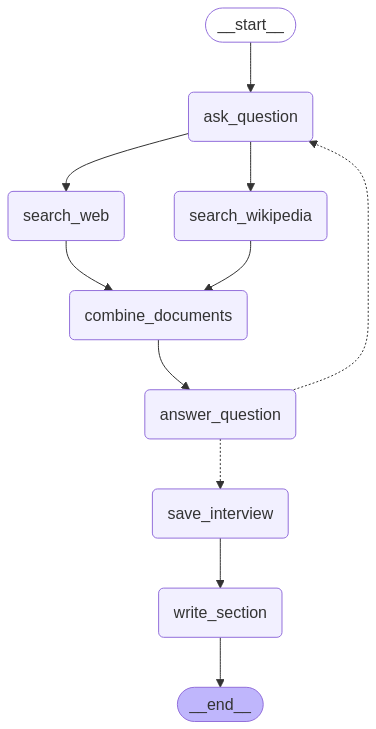

In [277]:
#  View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [275]:
type(meal_type_analysts[0])

__main__.MealTypeAnalysts

In [259]:
type(analysts_messages[0])

dict

In [269]:
analysts_messages[0].keys()

dict_keys(['analyst', 'messages'])

In [270]:
recommended_meals_testing = []
for event in interview_graph.stream({
    "user_profile": user,
    "meal_type_analysts": meal_type_analysts,
    "analysts_messages": analysts_messages,
    "sourced_documents": [],
    "interview": "",
    "recommended_meals": {
        "user_profile": user,
        "recommended_meals": []
    },
    "max_num_turns": 2
}, stream_mode="values"):
    recommended_meals_testing.append(event)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'You are an analyst tasked with interviewing an expert to learn about a specific topic.\n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Explore expert strategies related to high-protein diet — specifically, Protein Pete is here to pump up your breakfast with high-protein options that fit your dairy-free and low-carb lifestyle. He suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado, ensuring you start your day with the energy you need.\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue t

TypeError: list indices must be integers or slices, not str

In [271]:
recommended_meals_testing

[{'user_profile': UserProfile(name='Space Cadet', age=23, gender='Male', height_cm=183, weight_kg=65.0, activity_level='Lightly active', dietary_preferences=['Dairy-Free', 'Low-Carb'], allergies=['Peanuts'], health_conditions=['None'], weight_goal='Maintain weight', past_meals=[]),
  'max_num_turns': 2,
  'web_documents': [],
  'wiki_documents': [],
  'sourced_documents': [],
  'meal_type_analysts': [MealTypeAnalysts(meal_type='BREAKFAST', analysts=[Analyst(name='Protein Pete', tone='Energetic', theme='High-Protein Diet', description='Protein Pete is here to pump up your breakfast with high-protein options that fit your dairy-free and low-carb lifestyle. He suggests meals like scrambled eggs with spinach and turkey bacon, or a tofu scramble with avocado, ensuring you start your day with the energy you need.'), Analyst(name='Carb-Conscious Carla', tone='Practical', theme='Low-Carb Options', description='Carb-Conscious Carla focuses on keeping your breakfast low in carbs while still bein